In [1]:
import os
DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture/"
OUTPUT_DATASET_PATH = "/Users/aref/dvs-dataset/cleaned_cache"
    
if not os.path.exists(DATASET_FOLDER_PATH):
    raise Exception('can not access data folder.')
    
def debug_print(*msgs):
    print ' '.join([str(m) for m in msgs])
    print '==========================================='
    raise Exception('got it?')
    
import numpy as np

In [2]:
from time import time
from datetime import datetime

_last_time_length = None
_iteration_left = None

def time_unit_creator(l_time):
    time_unit = 'seconds'
    if l_time >= 60:
        l_time /= 60
        time_unit = 'minutes'
    else:
        return l_time, time_unit
    
    if l_time >= 60:
        l_time /= 60
        time_unit = 'hours'
    else:
        return l_time, time_unit
    
    if l_time >= 24:
        l_time /= 24
        time_unit = 'days'
    else:
        return l_time, time_unit
        
    if l_time >= 30:
        l_time /= 30
        time_unit = 'month'
    else:
        return l_time, time_unit

def expector_timer(func):
    def wrapper(*args, **kwargs):
        global _last_time_length, _iteration_left
        t_start = time()
        
        if _last_time_length is not None:
            expectation = t_start
            if _iteration_left is not None:
                expectation +=  _last_time_length * _iteration_left
            else:
                expectation +=  _last_time_length
            datestr = datetime.fromtimestamp(expectation).strftime("%Y-%m-%d %H:%M:%S")
            print '[expecting to finish at %s]' % datestr
        res = func(*args, **kwargs)
        length = time() - t_start
        length, length_unit = time_unit_creator(length)
        print '[operation took %d %s]' % (length, length_unit)
        print '[operation finished at %s]' % datetime.fromtimestamp(time()).strftime("%Y-%m-%d %H:%M:%S")
        
        if _last_time_length is None:
            _last_time_length = length
        else:
            _last_time_length = .9 * _last_time_length + .1 * length
        return res
    return wrapper

In [3]:
# Load file list:
train_trail_file = 'trials_to_train.txt'
test_trail_file = 'trials_to_test.txt'

def load_trail_files(trail_file):
    file_list = []
    with open(os.path.join(DATASET_FOLDER_PATH, trail_file), 'r') as f:
        for line in f.readlines():
            aedat_file = line.strip()
            if not line:
                continue
            csv_file = aedat_file.replace('.aedat', '_labels.csv')
            file_list.append((
                os.path.join(DATASET_FOLDER_PATH, aedat_file),
                os.path.join(DATASET_FOLDER_PATH, csv_file)
            ))
    return file_list

def get_label(event_labels, timestamp):
    for t in event_labels.keys():
        if t > timestamp:
            return event_labels[t]
    return 0

def get_label_text(event_labels, timestamp):
    return gesture_mapping[get_label(event_labels, timestamp)]

# mapping
gesture_mapping = {
    0: 'no_gesture',
    1: 'hand_clapping',
    2: 'right_hand_wave',
    3: 'left_hand_wave',
    4: 'right_arm_clockwise',
    5: 'right_arm_counter_clockwise',
    6: 'left_arm_clockwise',
    7: 'left_arm_counter_clockwise',
    8: 'arm_roll',
    9: 'air_drums',
    10: 'air_guitar',
    11: 'other_gestures',
}

# loading file lists
file_list_train = load_trail_files(train_trail_file)
file_list_test = load_trail_files(test_trail_file)

In [4]:
# Data Reader

import struct
from collections import OrderedDict

DEBUG_PRINT = False

class EOF(Exception):
    pass


def read_file(f, size, unpack_type=None):
    d = f.read(size)
    if d == '':
        raise EOF()
    if unpack_type is None:
        unpack_type = 'H' if size == 2 else 'I'
    return struct.unpack(unpack_type, d)[0]


def skip_file_header(f):
    line_counter = 0
    line = '#'
    while line.startswith('#') and not line.startswith('#!END-HEADER'):
        line = f.readline()


def read_header(f):
    header = OrderedDict([
        ('eventType', read_file(f, 2)),
        ('eventSource', read_file(f, 2)),
        ('eventSize', read_file(f, 4)),
        ('eventTSOffset', read_file(f, 4)),
        ('eventTSOverflow', read_file(f, 4)),
        ('eventCapacity', read_file(f, 4)),
        ('eventNumber', read_file(f, 4)),
        ('eventValid', read_file(f, 4)),
    ])
    return header


def read_event(f, timestamp_offset):
    data = read_file(f, 4)
    timestamp = read_file(f, 4, 'i')
    x = ( data >> 17 ) & 0x00001FFF
    y = ( data >> 2 ) & 0x00001FFF
    polarity = ( data >> 1 ) & 0x00000001
    return {
        'x': x,
        'y': y,
        'polarity': polarity,
        'timestamp': timestamp + timestamp_offset * 2**31,
        'data': data,
    }


def load_dataset(file_path):
    event_list = []
    with open(file_path, 'rb') as f:
        skip_file_header(f)
        
        while True:
            try:
                header = read_header(f)
                if DEBUG_PRINT:
                    for k, v in header.items():
                        print('%15s:  %d' % (k, v))
                    print('--------------------------')

                event_number = header['eventNumber']
                for i in range(event_number):
                    event = read_event(f, header['eventTSOffset'])
                    event_list.append(event)
                event_list.append('clear')
            except EOF:
                break
    return event_list

def read_file_all(file_name):
    if DEBUG_PRINT:
        print('loading dataset...')
    event_list = load_dataset(file_name)
    if DEBUG_PRINT:
        print('done!')
    return event_list


In [5]:
# cache generator

def read_event_labels(path):
    label_began_time = None
    event_labels = OrderedDict()
    with open(path, 'r') as f:
        for line in f.readlines():
            label, start, end = line.strip().split(',')
#             print '%5s\t%15s\t%15s' % (label, start, end)
            try:
                label = int(label)
                start = int(start)
                end = int(end)
            except ValueError:
                continue
            if label_began_time is None:
                label_began_time = start

            event_labels[start] = 0
            event_labels[end] = label
    return event_labels, label_began_time


def serialize_events(x_data, y_data, z_data):
    scale_w_inv = 128 / DESIRED_WIDTH
    scale_h_inv = 128 / DESIRED_HEIGHT
    
    x_train = []
    y_train = []
    
    ev_times = z_data
    frames = 0
    max_time = np.max(ev_times)
    current_time = np.min(ev_times)
    while (current_time < max_time):
        ev_lb = ev_times > current_time
        ev_ub = ev_times < (current_time + FRAME_LENGTH_US)

        event_x = x_data[ev_lb & ev_ub, :]
        event_y = y_data[ev_lb & ev_ub]

        retina = np.zeros([DESIRED_HEIGHT, DESIRED_WIDTH])
        retina[event_x[:,0] / scale_h_inv, event_x[:,1] / scale_w_inv] = 1
        
        frame_y = np.round(np.mean(event_y))
        current_time += FRAME_LENGTH_US
        
        frames += 1
        x_train.append(retina.flatten())
        y_train.append(frame_y)
        
    return np.array(x_train), np.array(y_train)


@expector_timer
def read_and_process_file(file_name_set, trail, counter):
    ev_x = []
    ev_y = []
    ev_z = []

    print '---> reading "%s"' % file_name_set[0]
    event_labels, label_began_time = read_event_labels(file_name_set[1])
    event_list = read_file_all(file_name_set[0])

    print('---> pre-processing file...')
    stream_begin_time = None
    stream_end_time = None

    frame_counter = 0
    for e in event_list:
        if e == 'clear':
            frame_counter += 1
            continue
            
        # calculate time information
        event_time = e['timestamp']
        if stream_begin_time is None:
            stream_begin_time = event_time
        event_corrected_time = event_time - stream_begin_time + label_began_time
        event_label = get_label(event_labels, event_corrected_time)

        # append event
        ev = (e['x'], e['y'])
        ev_x.append(ev)
        ev_y.append(event_label)
        ev_z.append(e['timestamp'])

    print('---> processing file...')
    x_train, y_train = serialize_events(np.array(ev_x), np.array(ev_y), np.array(ev_z))

    print '---> saving file...'
    x_train = np.array(x_train, dtype='uint8')
    y_train = np.array(y_train, dtype='uint8')
    np.save(file="%s_%s/x_%s_%d" % (OUTPUT_DATASET_PATH, trail, trail, counter), arr=x_train)
    np.save(file="%s_%s/y_%s_%d" % (OUTPUT_DATASET_PATH, trail, trail, counter), arr=y_train)
#     return x_train, y_train


def cache_data(trail, file_list):
    global _iteration_left
    counter = 0
    for file_name_set in file_list:
        _iteration_left = len(file_list) - counter
        counter += 1
        print '     ------------------------- %d out of %d -------------------------' % (counter, len(file_list))
        read_and_process_file(file_name_set, trail, counter)


In [6]:
DESIRED_WIDTH = 64
DESIRED_HEIGHT = 64

FRAME_LENGTH_US = 9.9 * 1000 # almost the same delay in each frame in the DVS data
FRAMES_COUNT = 100  # window_size = frame_count * frame_length_us

BATCH_SIZE = 16
SHUFFLE_THE_FRAMES = False

# cache_data('train', file_list_train)
cache_data('test', file_list_test)

     ------------------------- 1 out of 24 -------------------------
---> reading "/Users/aref/dvs-dataset/DvsGesture/user24_fluorescent.aedat"
---> pre-processing file...
---> processing file...
---> saving file...
[operation took 12 minutes]
[operation finished at 2019-10-19 11:48:12]
     ------------------------- 2 out of 24 -------------------------
[expecting to finish at 2019-10-19 11:53:03]
---> reading "/Users/aref/dvs-dataset/DvsGesture/user24_fluorescent_led.aedat"
---> pre-processing file...
---> processing file...
---> saving file...
[operation took 6 minutes]
[operation finished at 2019-10-19 11:54:56]
     ------------------------- 3 out of 24 -------------------------
[expecting to finish at 2019-10-19 11:59:21]
---> reading "/Users/aref/dvs-dataset/DvsGesture/user24_led.aedat"
---> pre-processing file...
---> processing file...
---> saving file...
[operation took 7 minutes]
[operation finished at 2019-10-19 12:02:03]
     ------------------------- 4 out of 24 ---------

---> reading "/Users/aref/dvs-dataset/DvsGesture/user24_fluorescent.aedat"
---> pre-processing file...


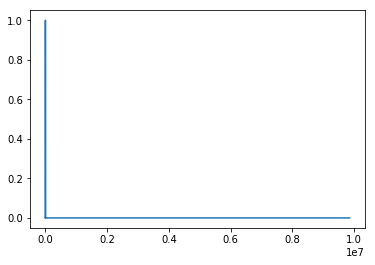

In [11]:
%matplotlib inline
from random import random

def serialize_events_t(x_data, y_data, z_data):
    scale_w_inv = 128 / DESIRED_WIDTH
    scale_h_inv = 128 / DESIRED_HEIGHT
    
    x_train = []
    y_train = []
    
    ev_times = z_data
    frames = 0
    max_time = np.max(ev_times)
    current_time = np.min(ev_times)
    while (current_time < max_time):
        if random() > 0.9:
            ev_lb = ev_times > current_time
            ev_ub = ev_times < (current_time + FRAME_LENGTH_US)

            ev_select = ev_lb & ev_ub
            plt.plot(ev_select)
            plt.show()
            break

        current_time += FRAME_LENGTH_US
        



file_name_set = file_list_test[0]
ev_x = []
ev_y = []
ev_z = []

print '---> reading "%s"' % file_name_set[0]
event_labels, label_began_time = read_event_labels(file_name_set[1])
event_list = read_file_all(file_name_set[0])

print('---> pre-processing file...')
stream_begin_time = None
stream_end_time = None

frame_counter = 0
for e in event_list:
    if e == 'clear':
        frame_counter += 1
        continue

    # calculate time information
    event_time = e['timestamp']
    if stream_begin_time is None:
        stream_begin_time = event_time
    event_corrected_time = event_time - stream_begin_time + label_began_time
    event_label = get_label(event_labels, event_corrected_time)

    # append event
    ev = (e['x'], e['y'])
    ev_x.append(ev)
    ev_y.append(event_label)
    ev_z.append(e['timestamp'])

serialize_events_t(np.array(ev_x), np.array(ev_y), np.array(ev_z))
print 'done'